In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import itertools
import cv2
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
import plotly.express as px
import random
import zipfile
from PIL import Image
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging
tf.get_logger().setLevel(logging.ERROR)

/home/mattmori/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-03-15 10:48:19.109076: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 10:48:20.246754: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 10:48:20.248380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 10:48:20.503197: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cu

Define Data Path and Data Set Name

In [2]:
# Generate dataframe of the image paths and the corresponding label
data_dir = 'pet_images'

def gen_df_from_directory(data_dir):
    #Identifies and stores filepaths to images in images variables
    #Labels images according to the file they were found in.
    
    image_paths = []
    labels = []

    files = os.listdir(data_dir)
    for file in files:
        if file == 'Master Folder':
            continue
            
        filepath = os.path.join(data_dir, file)
        imagelist = os.listdir(filepath)
        
        for im in imagelist:
            im_path = os.path.join(filepath, im)
            image_paths.append(im_path)
            labels.append(file)
    
    col_1 = pd.Series(image_paths, name= 'image_paths')
    col_2 = pd.Series(labels, name='labels')
    df = pd.concat([col_1, col_2], axis= 1)


    return image_paths, labels, df


image_paths, labels, df = gen_df_from_directory(data_dir)

In [3]:
df.head()

image_paths labels
0  pet_images/Angry/02.jpg  Angry
1  pet_images/Angry/03.jpg  Angry
2  pet_images/Angry/04.jpg  Angry
3  pet_images/Angry/05.jpg  Angry
4  pet_images/Angry/06.jpg  Angry

In [4]:
def explore_data(df, name='df'):
    num_images = df.shape[0]
    num_classes = len(df['labels'].unique())
    
    print(f"This dataset has {num_images} images and {num_classes} classes.")
    print()
    print("There are:")
   
    for label, group in df.groupby('labels'):
        num_class = len(group)
        print(f"{num_class} {label} images")
        
        
explore_data(df)

This dataset has 1005 images and 4 classes.

There are:
250 Angry images
255 Other images
250 Sad images
250 happy images


Define Data Path and Data Set Name

Spliting the dataframe into train, valid, and test

In [5]:
train_df, temp_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)
valid_df, test_df = train_test_split(temp_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [6]:
explore_data(train_df)

This dataset has 804 images and 4 classes.

There are:
195 Angry images
216 Other images
193 Sad images
200 happy images


In [7]:
explore_data(valid_df)

This dataset has 120 images and 4 classes.

There are:
31 Angry images
25 Other images
31 Sad images
33 happy images


In [8]:
explore_data(test_df)

This dataset has 81 images and 4 classes.

There are:
24 Angry images
14 Other images
26 Sad images
17 happy images


Create Image Data Generator

In [9]:
batch_size = 24
img_size = (224, 224)
rgb = 3
img_shape = (img_size[0], img_size[1], rgb)


def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=25,
                           width_shift_range=0.25,
                           height_shift_range=0.25,
                           zoom_range=0.25)
                        
ts_gen = ImageDataGenerator(preprocessing_function= scalar,
                           rotation_range=25,
                           width_shift_range=0.25,
                           height_shift_range=0.25,
                           zoom_range=0.25)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                        x_col= 'image_paths', 
                                        y_col= 'labels', 
                                        target_size= img_size, 
                                        class_mode= 'categorical',
                                        color_mode= 'rgb', 
                                        shuffle= True, 
                                        batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                        x_col= 'image_paths', 
                                        y_col= 'labels', 
                                        target_size= img_size, 
                                        class_mode= 'categorical',
                                        color_mode= 'rgb', 
                                        shuffle= True, 
                                        batch_size= batch_size)


test_gen = ts_gen.flow_from_dataframe(test_df, 
                                       x_col= 'image_paths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= False, 
                                       batch_size= batch_size)

Found 804 validated image filenames belonging to 4 classes.
Found 120 validated image filenames belonging to 4 classes.
Found 81 validated image filenames belonging to 4 classes.


Visualizing the Data Set

In [10]:
counts = df['labels'].value_counts()
fig = go.Figure(go.Bar(
            x= counts.values,
            y=counts.index,
            orientation='h'))

fig.update_layout(title='Data Distribution in Bars',font_size=15,title_x=0.45)

In [11]:
Happy = df.groupby("labels").get_group("happy")
Sad = df.groupby("labels").get_group("Sad")
Angry = df.groupby("labels").get_group("Angry")
Other = df.groupby("labels").get_group("Other")

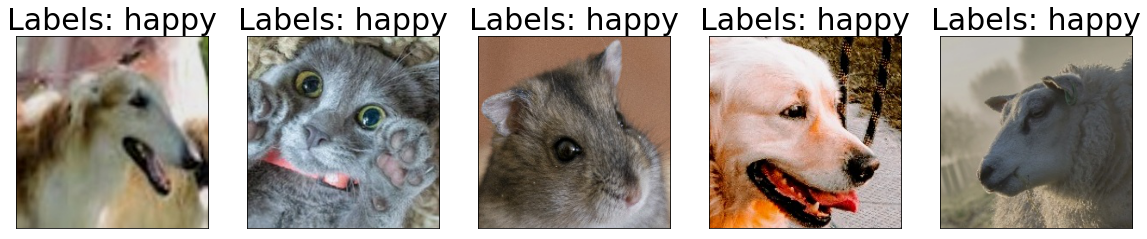

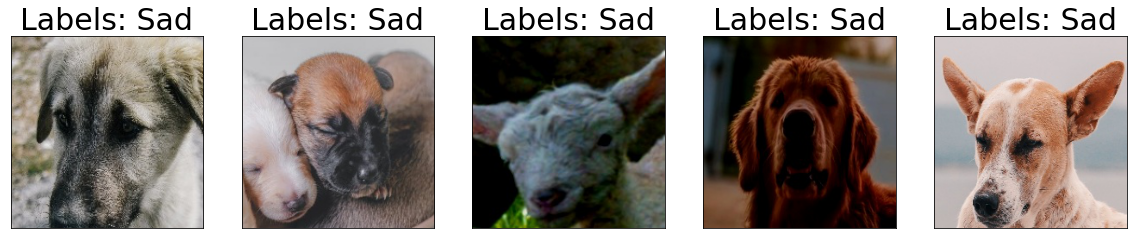

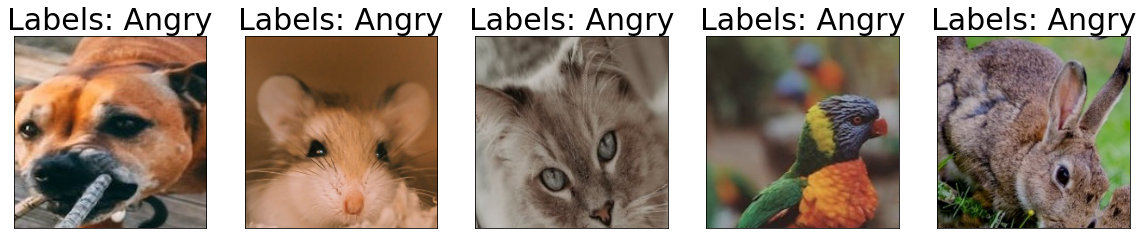

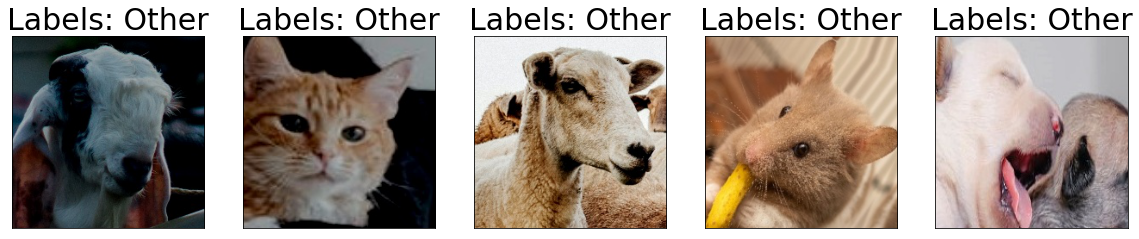

In [12]:
def plot_emotions(emotion):
    fig, axes = plt.subplots(ncols = 5,nrows = 1, figsize=(20, 20))
    for i in range(0,5):
        index = random.sample(range(len(emotion)),1)
        index = int(''.join(map(str, index)))

        filename = emotion.iloc[index]["image_paths"]
        label = emotion.iloc[index]["labels"]
        image = Image.open(filename)
        axes[i].imshow(image)
        axes[i].set_title("Labels: " + label, fontsize = 30)
        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])
    

    plt.show()
    
plot_emotions(Happy)
plot_emotions(Sad)
plot_emotions(Angry)
plot_emotions(Other)

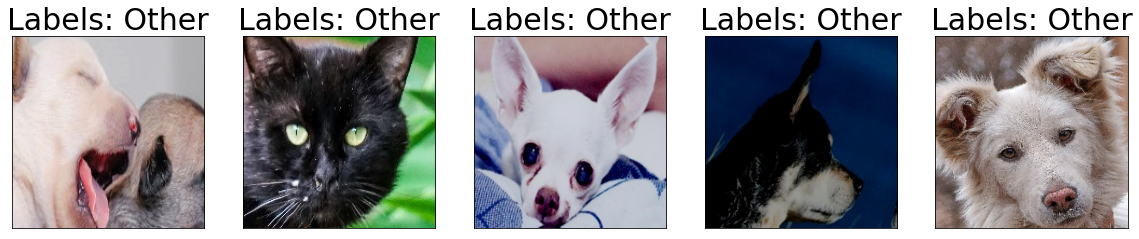

In [13]:
def show_similar_img(label):
    if label == "Angry":
        plot_emotions(Angry)
    elif label == "Other":
        plot_emotions(Other)
    elif label == "Sad":
        plot_emotions(Sad)
    elif label == "Happy":
        plot_emotions(Happy)

show_similar_img("Other")

Model Building

In [14]:
img_size = (300, 300)
rgb = 3
img_shape = (img_size[0], img_size[1], rgb)
class_count = len(list(train_gen.class_indices.keys())) 

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", drop_connect_rate = 0.60, input_shape= img_shape, pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    #Transfer Learning: Classifies features extracted by the model
    Dense(256, activation='relu'),
    Dense(class_count, activation= 'softmax')
])
model.summary()

2024-03-15 10:48:43.425973: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:3b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-15 10:48:43.427036: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11184179 (42.66 MB)
Trainable params: 397572 (1.52 MB)
Non-trainable params: 10786607 (41.15 MB)
_________________________________________________________________


In [15]:
model.compile(optimizer = SGD(learning_rate=0.1), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [16]:
step_size_train= train_gen.n // train_gen.batch_size
step_size_valid= valid_gen.n // valid_gen.batch_size

import time
start_time = time.time()
batch_size = 16  
history = model.fit(x=train_gen,
                    epochs= 60,
                    verbose= 1,
                    steps_per_epoch = step_size_train,
                    validation_data= valid_gen, 
                    validation_steps= step_size_valid)
                

print("My program took", time.time() - start_time, "to run")

Epoch 1/60
33/33 [==============================] - 62s 2s/step - loss: 1.7610 - accuracy: 0.4179 - val_loss: 1.3442 - val_accuracy: 0.5250
Epoch 2/60
33/33 [==============================] - 49s 1s/step - loss: 1.2742 - accuracy: 0.5154 - val_loss: 1.1322 - val_accuracy: 0.5333
Epoch 3/60
33/33 [==============================] - 49s 1s/step - loss: 1.0874 - accuracy: 0.5833 - val_loss: 0.9083 - val_accuracy: 0.7000
Epoch 4/60
33/33 [==============================] - 54s 2s/step - loss: 0.9600 - accuracy: 0.6192 - val_loss: 0.7018 - val_accuracy: 0.7167
Epoch 5/60
33/33 [==============================] - 52s 2s/step - loss: 0.7675 - accuracy: 0.7064 - val_loss: 0.6958 - val_accuracy: 0.7250
Epoch 6/60
33/33 [==============================] - 67s 2s/step - loss: 0.8231 - accuracy: 0.6936 - val_loss: 0.7399 - val_accuracy: 0.7000
Epoch 7/60
33/33 [==============================] - 59s 2s/step - loss: 0.8190 - accuracy: 0.6987 - val_loss: 0.8281 - val_accuracy: 0.7250
Epoch 8/60
33/33 [==

33/33 [==============================] - 42s 1s/step - loss: 0.1823 - accuracy: 0.9397 - val_loss: 0.3106 - val_accuracy: 0.9083
Epoch 60/60
33/33 [==============================] - 44s 1s/step - loss: 0.1946 - accuracy: 0.9436 - val_loss: 0.2636 - val_accuracy: 0.9333
My program took 2878.323174238205 to run


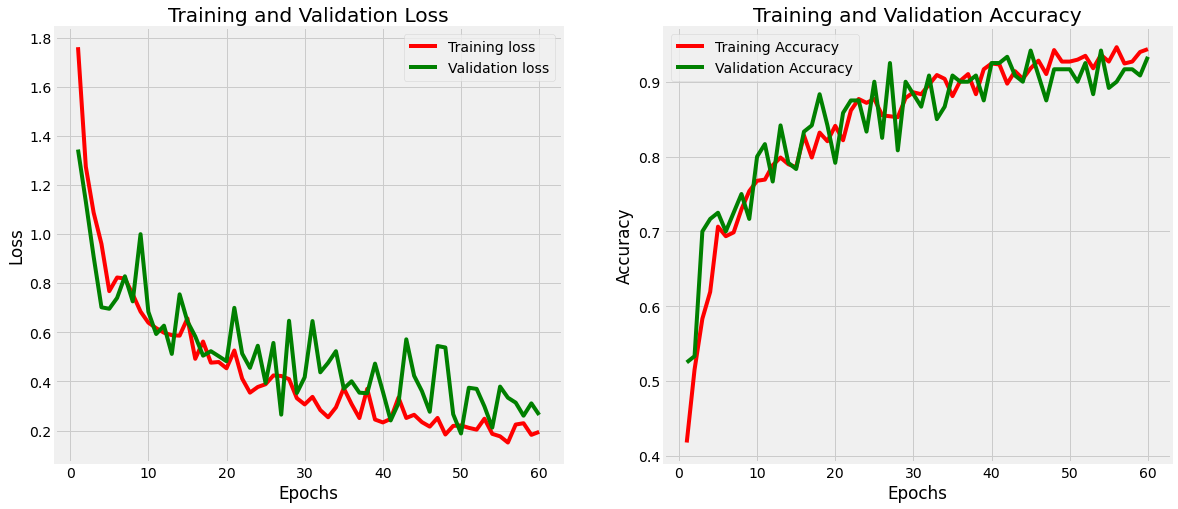

In [17]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [18]:
train_score = model.evaluate(train_gen, steps= batch_size, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= batch_size, verbose= 1)
test_score = model.evaluate(test_gen, steps= batch_size, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 4s 181ms/step - loss: 0.1794 - accuracy: 0.9383
Train Loss:  0.0451277457177639
Train Accuracy:  0.9791666865348816
--------------------
Validation Loss:  0.24427875876426697
Validation Accuracy:  0.9333333373069763
--------------------
Test Loss:  0.17938284575939178
Test Accuracy:  0.9382715821266174


In [19]:
img_size = (300, 300)
rgb = 3
img_shape = (img_size[0], img_size[1], rgb)
class_count = len(list(train_gen.class_indices.keys())) 

base_model = tf.keras.applications.efficientnet.EfficientNetB4(include_top= False, weights= "imagenet", drop_connect_rate = 0.60, input_shape= img_shape, pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    #Transfer Learning: Classifies features extracted by the model
    Dense(256, activation='relu'),
    Dense(class_count, activation= 'softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 1792)              17673823  
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1792)              7168      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               459008    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 18141027 (69.20 MB)
Trainable params: 463620 (1.77 MB)
Non-trainable params: 17677407 (67.43 MB)
_________________________________________________________________


Compiling the Model

In [20]:
model.compile(optimizer = SGD(learning_rate=0.1), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

Training the Model

In [21]:
step_size_train= train_gen.n // train_gen.batch_size
step_size_valid= valid_gen.n // valid_gen.batch_size

import time
start_time = time.time()
batch_size = 16  
history = model.fit(x=train_gen,
                    epochs= 60,
                    verbose= 1,
                    steps_per_epoch = step_size_train,
                    validation_data= valid_gen, 
                    validation_steps= step_size_valid)
                

print("My program took", time.time() - start_time, "to run")




Epoch 1/60
33/33 [==============================] - 73s 2s/step - loss: 2.1041 - accuracy: 0.3667 - val_loss: 1.4646 - val_accuracy: 0.5333
Epoch 2/60
33/33 [==============================] - 58s 2s/step - loss: 1.3260 - accuracy: 0.4744 - val_loss: 1.4314 - val_accuracy: 0.5000
Epoch 3/60
33/33 [==============================] - 63s 2s/step - loss: 1.2322 - accuracy: 0.5192 - val_loss: 1.0402 - val_accuracy: 0.6667
Epoch 4/60
33/33 [==============================] - 59s 2s/step - loss: 1.1454 - accuracy: 0.5769 - val_loss: 0.9567 - val_accuracy: 0.6583
Epoch 5/60
33/33 [==============================] - 59s 2s/step - loss: 1.1005 - accuracy: 0.5628 - val_loss: 0.8575 - val_accuracy: 0.7417
Epoch 6/60
33/33 [==============================] - 57s 2s/step - loss: 1.0411 - accuracy: 0.5949 - val_loss: 0.9058 - val_accuracy: 0.6667
Epoch 7/60
33/33 [==============================] - 58s 2s/step - loss: 0.9415 - accuracy: 0.6513 - val_loss: 0.8715 - val_accuracy: 0.6750
Epoch 8/60
33/33 [==

33/33 [==============================] - 59s 2s/step - loss: 0.2562 - accuracy: 0.9179 - val_loss: 0.2798 - val_accuracy: 0.9167
Epoch 60/60
33/33 [==============================] - 57s 2s/step - loss: 0.2485 - accuracy: 0.9077 - val_loss: 0.4351 - val_accuracy: 0.8917
My program took 3531.4690544605255 to run


Evaluating the Model

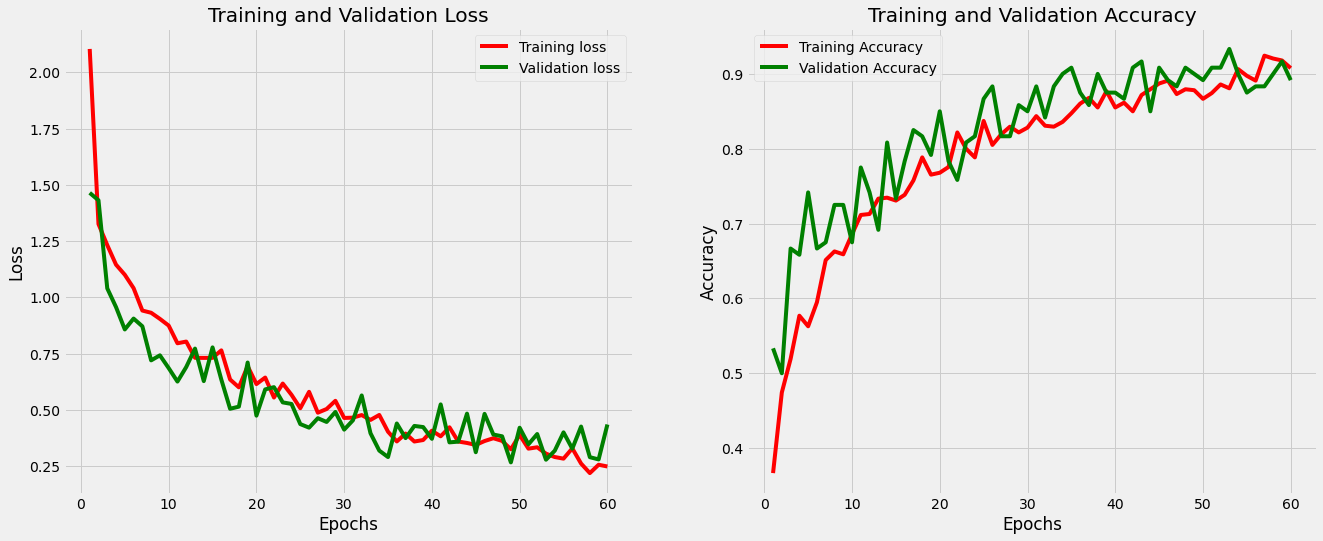

In [22]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Model Accuracy 

In [23]:
train_score = model.evaluate(train_gen, steps= batch_size, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= batch_size, verbose= 1)
test_score = model.evaluate(test_gen, steps= batch_size, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


16/16 [==============================] - 5s 232ms/step - loss: 0.2985 - accuracy: 0.9259
Train Loss:  0.0772714838385582
Train Accuracy:  0.9921875
--------------------
Validation Loss:  0.28622865676879883
Validation Accuracy:  0.925000011920929
--------------------
Test Loss:  0.298530638217926
Test Accuracy:  0.9259259104728699


In [25]:
preds_1 = model.predict_generator(test_gen)
y_pred_1 = np.argmax(preds_1, axis=1)

/tmp/ipykernel_3633/3354647490.py:1: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [26]:
img_size = (300, 300)
rgb = 3
img_shape = (img_size[0], img_size[1], rgb)
class_count = len(list(train_gen.class_indices.keys())) 

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", drop_connect_rate = 0.60, input_shape= img_shape, pooling= 'max')
base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    #Transfer Learning: Classifies features extracted by the model
    Dense(256, activation='relu'),
    Dense(class_count, activation= 'softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization_2 (Bat  (None, 1536)              6144      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               393472    
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11184179 (42.66 MB)
Trainable params: 397572 (1.52 MB)
Non-trainable params: 10786607 (41.15 MB)
_________________________________________________________________


In [27]:
model.compile(optimizer = RMSprop(learning_rate=0.001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [28]:
step_size_train= train_gen.n // train_gen.batch_size
step_size_valid= valid_gen.n // valid_gen.batch_size

import time
start_time = time.time()
batch_size = 16  
history = model.fit(x=train_gen,
                    epochs= 60,
                    verbose= 1,
                    steps_per_epoch = step_size_train,
                    validation_data= valid_gen, 
                    validation_steps= step_size_valid)
                   

print("My program took", time.time() - start_time, "to run")


Epoch 1/60
33/33 [==============================] - 57s 1s/step - loss: 1.8626 - accuracy: 0.4051 - val_loss: 1.5199 - val_accuracy: 0.5417
Epoch 2/60
33/33 [==============================] - 45s 1s/step - loss: 1.2217 - accuracy: 0.5756 - val_loss: 1.1686 - val_accuracy: 0.6250
Epoch 3/60
33/33 [==============================] - 46s 1s/step - loss: 1.0310 - accuracy: 0.6256 - val_loss: 0.7463 - val_accuracy: 0.7500
Epoch 4/60
33/33 [==============================] - 43s 1s/step - loss: 0.9405 - accuracy: 0.6410 - val_loss: 0.6669 - val_accuracy: 0.8000
Epoch 5/60
33/33 [==============================] - 43s 1s/step - loss: 0.8209 - accuracy: 0.6974 - val_loss: 0.5361 - val_accuracy: 0.8000
Epoch 6/60
33/33 [==============================] - 44s 1s/step - loss: 0.8249 - accuracy: 0.7051 - val_loss: 0.4588 - val_accuracy: 0.8500
Epoch 7/60
33/33 [==============================] - 44s 1s/step - loss: 0.7077 - accuracy: 0.7474 - val_loss: 0.4593 - val_accuracy: 0.8750
Epoch 8/60
33/33 [==

33/33 [==============================] - 43s 1s/step - loss: 0.1436 - accuracy: 0.9551 - val_loss: 0.1790 - val_accuracy: 0.9417
Epoch 60/60
33/33 [==============================] - 46s 1s/step - loss: 0.1944 - accuracy: 0.9449 - val_loss: 0.1363 - val_accuracy: 0.9500
My program took 2676.3046147823334 to run


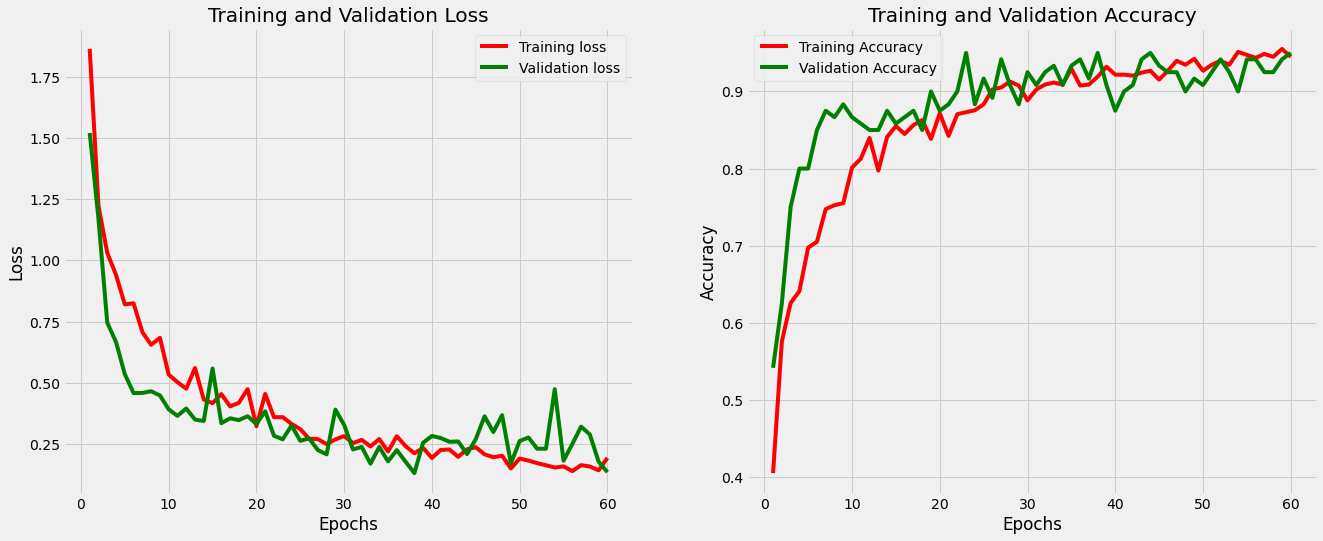

In [29]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [30]:
train_score = model.evaluate(train_gen, steps= batch_size, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= batch_size, verbose= 1)
test_score = model.evaluate(test_gen, steps= batch_size, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


16/16 [==============================] - 4s 176ms/step - loss: 0.2436 - accuracy: 0.9136
Train Loss:  0.01882527954876423
Train Accuracy:  0.9921875
--------------------
Validation Loss:  0.24559353291988373
Validation Accuracy:  0.9166666865348816
--------------------
Test Loss:  0.243554025888443
Test Accuracy:  0.9135802388191223


Getting the Prediction 

In [31]:
preds_2 = model.predict_generator(test_gen)
y_pred_2 = np.argmax(preds_2, axis=1)


/tmp/ipykernel_3633/1795433976.py:1: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



/tmp/ipykernel_3633/2594630873.py:1: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.

/tmp/ipykernel_3633/2594630873.py:13: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



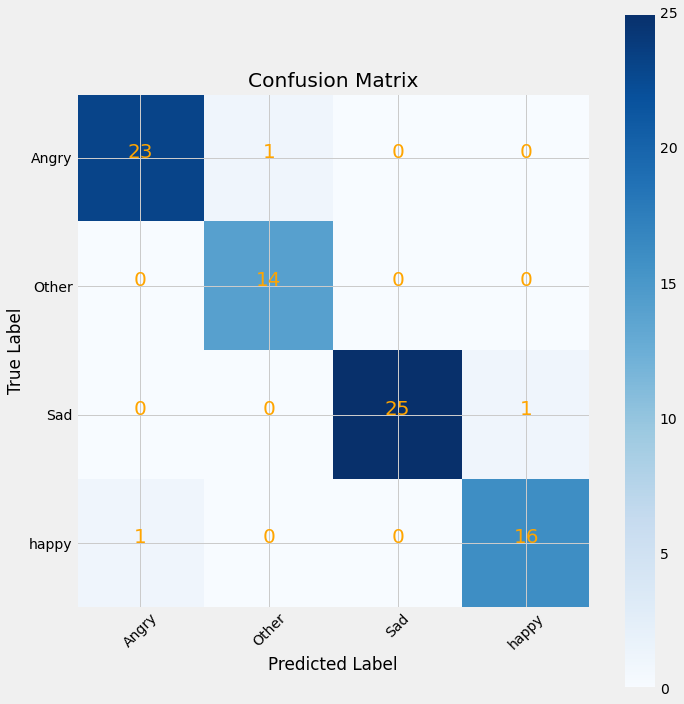

In [32]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)


classes = list(test_gen.class_indices.keys())


cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'orange', fontsize = 20)

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [33]:
#updated classifications
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

       Angry       0.96      0.96      0.96        24
       Other       0.93      1.00      0.97        14
         Sad       1.00      0.96      0.98        26
       happy       0.94      0.94      0.94        17

    accuracy                           0.96        81
   macro avg       0.96      0.97      0.96        81
weighted avg       0.96      0.96      0.96        81



Loading the Model and Predicting Inputs!

1/1 [==============================] - 2s 2s/step


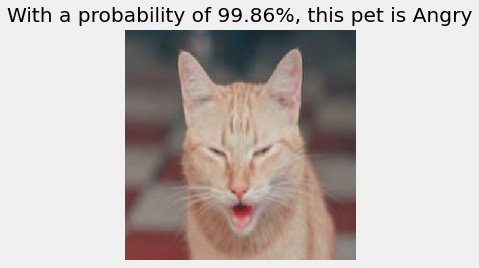

In [34]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_emotion(image_path, model):
    fig, ax = plt.subplots()
    img = image.load_img(image_path, target_size=(300, 300))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    pred = model.predict(img_array)
    acc = np.max(pred)
    acc = "{:.2f}".format(100*acc)
    pred_class_index = np.argmax(pred)
    
    class_indices = train_gen.class_indices
    class_labels = list(class_indices.keys())
    pred_label = class_labels[pred_class_index]
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    plt.imshow(img)
    
    
    #plt.axis('off')
    if pred_label == 'Other':
        plt.title(f"With a probability of {acc}%, this pet is content")
    else:
        plt.title(f"With a probability of {acc}%, this pet is {pred_label}")
    plt.show()



test_img = "pet_images/Angry/02.jpg"
predict_emotion(test_img, model)

In [35]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(train_gen.classes)
y_onehot_test = label_binarizer.transform(test_gen.classes)
y_onehot_test.shape  # (n_samples, n_classes)


train_gen.class_indices.keys()

dict_keys(['Angry', 'Other', 'Sad', 'happy'])

In [36]:
blank_probs = [0 for i in range(len(preds))]

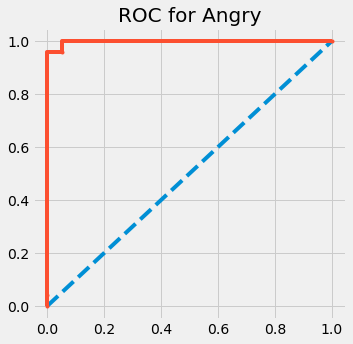

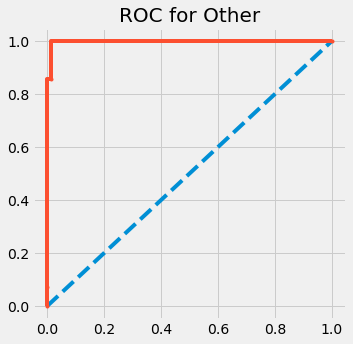

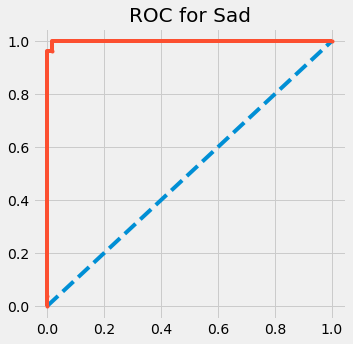

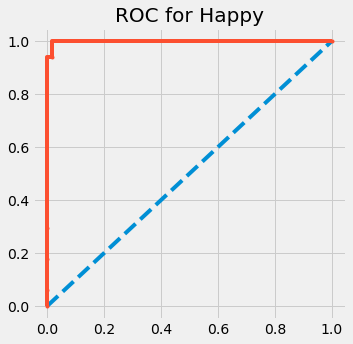

In [37]:
from sklearn.metrics import roc_curve
class_labels = ['Angry', 'Other', 'Sad', 'Happy']
for i in range(0,4):
    fig, axes = plt.subplots(ncols = 1,nrows = 1, figsize=(5, 5))
    fpr, tpr, thresholds = roc_curve(y_onehot_test[:,i], preds[:,i])
    b_fpr, b_tpr, b_thresholds = roc_curve(y_onehot_test[:,i], blank_probs)
    plt.plot(b_fpr, b_tpr, linestyle='--', label='baseline')
    plt.plot(fpr, tpr, marker='.', label='model')
    axes.set_title(f"ROC for {class_labels[i]}", fontsize = 20)

In [38]:
#model.save("97_model.h5")

In [39]:
# # load and evaluate a saved model
# from numpy import loadtxt
# from tensorflow.keras.models import load_model

# # model_test = load_model("95_model.h5")

In [40]:
#model_test.summary()

In [41]:

# image_path_to_test = "pet_images/sad/003.jpg"
# predict_and_display(image_path_to_test, model_test)

In [42]:
# ts_length = len(test_df)
# test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
# test_steps = ts_length // test_batch_size

# train_score = model_test.evaluate(train_gen, steps= test_steps, verbose= 1)
# valid_score = model_test.evaluate(valid_gen, steps= test_steps, verbose= 1)
# test_score = model_test.evaluate(test_gen, steps= test_steps, verbose= 1)

# print("Train Loss: ", train_score[0])
# print("Train Accuracy: ", train_score[1])
# print('-' * 20)
# print("Test Loss: ", test_score[0])
# print("Test Accuracy: ", test_score[1])


In [43]:
#model_test = load_model("95_model.h5")